In [1]:
import torch
import numpy as np
import sys; sys.path.append('../src/'); sys.path.append('..')
import matplotlib.pyplot as plt

In [2]:
from src.model.utils.metrics import l2_loss, explained_reconstruction, mean_correlation, importance_correlation, main_exprec
from src.least_volume_image import DCDiscriminator, TrueSNDCGenerator, AutoEncoder, DynamicPruningAE_v2, Adam, read_configs
from src.dataset.images import MNISTImages, CIFAR10Images
from torch.nn.functional import mse_loss
from math import sqrt

In [3]:
mnist_train = MNISTImages(True, device='cuda:5').images.data.unsqueeze(1).to('cuda:5') / 255
mnist_test = MNISTImages(False, device='cuda:5').images.data.unsqueeze(1).to('cuda:5') / 255

configs = read_configs('mnist', src='../src/')
ae = AutoEncoder(configs, DCDiscriminator, TrueSNDCGenerator, Adam).to('cuda:5')
ae.load('../saves/image/mnist/non10000.tar')
ae.eval()

AutoEncoder(
  (encoder): DCDiscriminator(
    (conv): Sequential(
      (0): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): Flatten(start_dim=1, end_dim=-1)
    )
    (critics): MLP(
      (model): Sequential(
        (0): LinearCombo(
          (model): Sequential(
            (0): Linear(in_features=1568, out_features=128, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
          )
        )
        (1): LinearCombo(
          (model): Sequential(
            (0): Linear(in_features=128, out_features=64, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
          )
        )
        (2): Linear(in_features=64, out_features=20

In [4]:
rec = ae.decode(ae.encode(mnist_train))
l2_loss(rec, mnist_train) / 28/28

tensor(0.0022, device='cuda:5', grad_fn=<DivBackward0>)

Comment: set epsilon to 0.005

In [5]:
mse_loss(rec, mnist_train)

tensor(0.0041, device='cuda:5', grad_fn=<MseLossBackward0>)

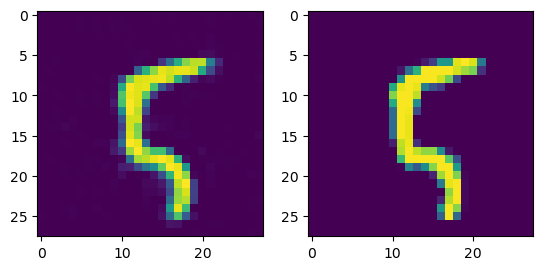

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec[100, 0].clip(0, 1).detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mnist_train[100, 0].detach().cpu())

In [7]:
rect = ae.decode(ae.encode(mnist_test))
l2_loss(rect, mnist_test)

tensor(1.8980, device='cuda:5', grad_fn=<MeanBackward0>)

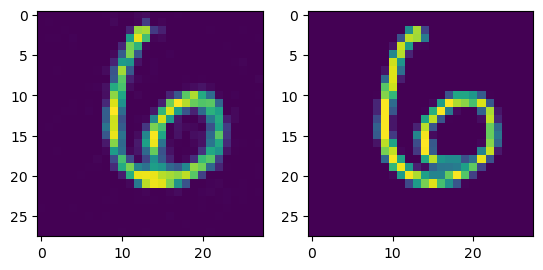

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect[100, 0].clip(0, 1).detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mnist_test[100, 0].detach().cpu())

# CIFAR10

In [9]:
cifar_train = torch.as_tensor(CIFAR10Images(True, device='cuda:5').images.data).to('cuda:5') / 255
cifar_test = torch.as_tensor(CIFAR10Images(False, device='cuda:5').images.data).to('cuda:5') / 255

configs = read_configs('cifar10', src='../src/')
ae = AutoEncoder(configs, DCDiscriminator, TrueSNDCGenerator, Adam).to('cuda:5')
ae.load('../saves/image/cifar10/non10000.tar')
ae.eval()

Files already downloaded and verified
Files already downloaded and verified


AutoEncoder(
  (encoder): DCDiscriminator(
    (conv): Sequential(
      (0): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): Conv2DCombo(
        (model): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Flatten(start_dim=1, end_dim=-1)
    )
    (critics): MLP(
      (model): Sequential(
        (0): LinearCombo(
          (model): Sequential(
            (0): Linear(in_features=2048, out_features=256, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
          )
        )
        (1): LinearCombo(
          (model): Seq

In [10]:
rec = ae.decode(ae.encode(cifar_train.permute(0, 3, 2, 1))).permute(0, 3, 2, 1)
l2_loss(rec, cifar_train)

tensor(4.3147, device='cuda:5', grad_fn=<MeanBackward0>)

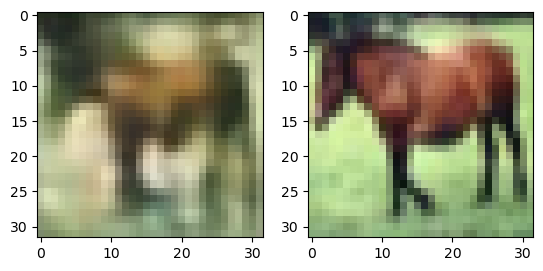

In [23]:
i=7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rec[i].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_train[i].detach().cpu())

In [12]:
rect = ae.decode(ae.encode(cifar_test.permute(0, 3, 2, 1))).permute(0, 3, 2, 1)
l2_loss(rect, cifar_test)

tensor(4.3113, device='cuda:5', grad_fn=<MeanBackward0>)

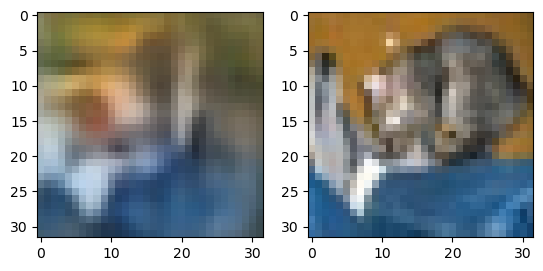

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect[0].detach().cpu())
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cifar_test[0].detach().cpu())